In [95]:
# !git clone https://github.com/anandbhoraskar/img2vec.git
# !cd img2vec && git pull origin master

# Loading necessary things

In [2]:
data_path = "../../data/FID-300/"

In [3]:
import sys
import os
sys.path.insert(1, 'img2vec')
from img2vec_pytorch import Img2Vec
import img2vec_pytorch
import importlib
importlib.reload(img2vec_pytorch)

from PIL import Image
import numpy as np

In [4]:
from scipy.io import loadmat
label_table = loadmat(os.path.join(data_path, 'label_table.mat'))
label_table = label_table['label_table']

In [5]:
references = np.arange(1, 1176)
# print(references)

test_val = np.arange(1, 301)
# print(test_val)

In [6]:
def file_path(i:int, data:str = 'ref'):
  if data == 'ref':
    # print('ref')
    return data_path+"/references/"+"{:05d}".format(i)+".png"
  else:
    # print('test')
    return data_path+"/tracks_cropped/"+"{:05d}".format(i)+".jpg"

In [7]:
print(file_path(1, 'ref'))
print(file_path(1, 'test'))

../../data/FID-300//references/00001.png
../../data/FID-300//tracks_cropped/00001.jpg


In [8]:
ref_img_list = []
for i in references:
  img = Image.open(file_path(i,'ref'))
  img = img.convert("RGB")
  ref_img_list.append(img)

In [9]:
test_img_list = []
for i in test_val:
  img = Image.open(file_path(i,'test'))
  img = img.convert("RGB")
  test_img_list.append(img)

## Sample run

In [10]:
import img2vec_pytorch
import importlib
importlib.reload(img2vec_pytorch)
img2vec = img2vec_pytorch.Img2Vec(cuda=True, layer_output_size=512)

In [11]:
ref_vec_list = []
test_vec_list = []

ref_vec_list = [img2vec.get_vec(img, tensor=True) for img in ref_img_list]
test_vec_list = [img2vec.get_vec(img, tensor=True) for img in test_img_list]

In [12]:
ref_vec_list_np = np.array([np.array(vec) for vec in ref_vec_list])
test_vec_list_np = np.array([np.array(vec) for vec in test_vec_list])

In [13]:
ref_vec_list_np = ref_vec_list_np.reshape(1175, 2048)
test_vec_list_np = test_vec_list_np.reshape(300, 2048)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
score = cosine_similarity(test_vec_list_np, ref_vec_list_np)

In [15]:
score_sort = (-score).argsort(1)

In [16]:
pos_array = []
for a,b,c in zip(score_sort, score.argmax(1), label_table[:, 1]-1):
  pos_array.append(np.where(a==c)[0][0])
pos_array = np.array(pos_array)
  

In [17]:
t = 5
thresh = t*pos_array.shape[0]/100
acc = 100*np.sum((pos_array<thresh))/pos_array.shape[0]
print("top {}: {}".format(t, acc))

top 5: 22.666666666666668


In [18]:
t = 10
thresh = t*pos_array.shape[0]/100
acc = 100*np.sum((pos_array<thresh))/pos_array.shape[0]
print("top {}: {}".format(t, acc))

top 10: 32.666666666666664


# Define reusable functions

In [19]:
def find_scores(img2vec, layer_output_size=512, return_tensor=False):
  if return_tensor:
    ref_vec_list = np.array([img2vec.get_vec(img).mean(1).flatten().numpy() for img in ref_img_list])
    test_vec_list = np.array([img2vec.get_vec(img).mean(1).flatten().numpy() for img in test_img_list])
  else:
    ref_vec_list = np.array([img2vec.get_vec(img) for img in ref_img_list])
    test_vec_list = np.array([img2vec.get_vec(img) for img in test_img_list])

  ref_vec_list = ref_vec_list.reshape(1175, layer_output_size)
  test_vec_list = test_vec_list.reshape(300, layer_output_size)

  # test_vec_list = (test_vec_list-test_vec_list.mean(1)[:, None])/test_vec_list.std(1)[:, None]
  # ref_vec_list = (ref_vec_list-ref_vec_list.mean(1)[:, None])/ref_vec_list.std(1)[:, None]
  score = cosine_similarity(test_vec_list, ref_vec_list)
  score_sort = (-score).argsort(1)

  pos_array = []
  for a,b,c in zip(score_sort, score.argmax(1), label_table[:, 1]-1):
    pos_array.append(np.where(a==c)[0][0])
  pos_array = np.array(pos_array)

  t = 5
  thresh = t*pos_array.shape[0]/100
  acc = 100*np.sum((pos_array<thresh))/pos_array.shape[0]
  print("top {}: {}".format(t, acc))

  t = 10
  thresh = t*pos_array.shape[0]/100
  acc = 100*np.sum((pos_array<thresh))/pos_array.shape[0]
  print("top {}: {}".format(t, acc))
  return score

In [20]:
def mcncc(v1, v2):
  den = np.linalg.norm(v1, axis=1)*np.linalg.norm(v2, axis=1) + 1e-12
  num = (v1*v2).sum(axis=1)
  return (num/den).sum()

# def mcncc_all(test_vec_list, ref_vec_list):
#     den = np.linalg.norm(test_vec_list, axis=2)*np.linalg.norm(v2, axis=2) + 1e-12
#     num = (v1*v2).sum(axis=1)
    

def find_scores_mcncc(img2vec, layer_output_size=512, return_tensor=False):
  ref_vec_list = np.array([img2vec.get_vec(img).numpy() for img in ref_img_list])
  test_vec_list = np.array([img2vec.get_vec(img).numpy() for img in test_img_list])

  ref_vec_list = ref_vec_list.reshape(ref_vec_list.shape[0], ref_vec_list.shape[2],ref_vec_list.shape[3]*ref_vec_list.shape[4])
  test_vec_list = test_vec_list.reshape(test_vec_list.shape[0], test_vec_list.shape[2], test_vec_list.shape[3]*test_vec_list.shape[4])

  test_vec_list = (test_vec_list-test_vec_list.mean(1)[:, None])/test_vec_list.std(1)[:, None]
  ref_vec_list = (ref_vec_list-ref_vec_list.mean(1)[:, None])/ref_vec_list.std(1)[:, None]
    
  print("computing score")
#   score = mcncc_all(test_vec_list, ref_vec_list)
  score = np.zeros((test_vec_list.shape[0], ref_vec_list.shape[0]))
  for i, v1 in enumerate(test_vec_list):
    print(i)
    for j, v2 in enumerate(ref_vec_list):
      score[i, j] = mcncc(v1, v2)

  score_sort = (-score).argsort(1)

  pos_array = []
  for a,b,c in zip(score_sort, score.argmax(1), label_table[:, 1]-1):
    pos_array.append(np.where(a==c)[0][0])
  pos_array = np.array(pos_array)

  t = 5
  thresh = t*pos_array.shape[0]/100
  acc = 100*np.sum((pos_array<thresh))/pos_array.shape[0]
  print("top {}: {}".format(t, acc))

  t = 10
  thresh = t*pos_array.shape[0]/100
  acc = 100*np.sum((pos_array<thresh))/pos_array.shape[0]
  print("top {}: {}".format(t, acc))
  return score

# Best performing  model

In [25]:
# Best performing
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer3', layer_output_size=256, 
    channels=14, return_embedding=True)

ref_vec_list = np.array([img2vec.get_vec(img).numpy() for img in ref_img_list])
test_vec_list = np.array([img2vec.get_vec(img).numpy() for img in test_img_list])

ref_vec_list = ref_vec_list.reshape(ref_vec_list.shape[0], ref_vec_list.shape[2],ref_vec_list.shape[3]*ref_vec_list.shape[4])
test_vec_list = test_vec_list.reshape(test_vec_list.shape[0], test_vec_list.shape[2], test_vec_list.shape[3]*test_vec_list.shape[4])

test_vec_list = (test_vec_list-test_vec_list.mean(1)[:, None])/test_vec_list.std(1)[:, None]
ref_vec_list = (ref_vec_list-ref_vec_list.mean(1)[:, None])/ref_vec_list.std(1)[:, None]

print("computing score")
#   score = mcncc_all(test_vec_list, ref_vec_list)
score = np.zeros((test_vec_list.shape[0], ref_vec_list.shape[0]))
for i, v1 in enumerate(test_vec_list):
    print(i)
    for j, v2 in enumerate(ref_vec_list):
        score[i, j] = mcncc(v1, v2)

score_sort = (-score).argsort(1)

pos_array = []
for a,b,c in zip(score_sort, score.argmax(1), label_table[:, 1]-1):
    pos_array.append(np.where(a==c)[0][0])
pos_array = np.array(pos_array)

computing score
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
27

# Plotting examples

In [56]:
import  matplotlib.pyplot as plt
def f(i):
    fig, ax = plt.subplots(1, 6, figsize=(10,5))
#     plt.subplot(5)
#     plt.figure()
    ax[0].axis('off')
    ax[0].imshow(test_img_list[i])
    for j in range(0, 5):
        plt.figure()
        ax[j+1].axis('off')
        ax[j+1].imshow(ref_img_list[score_sort[i][j]])

0


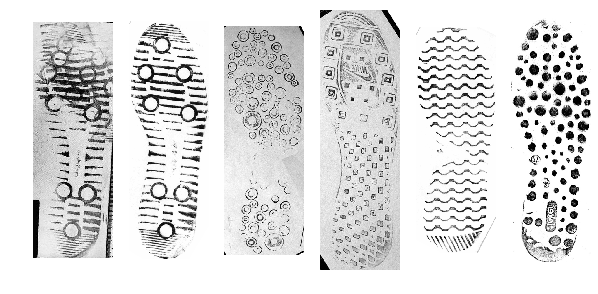

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

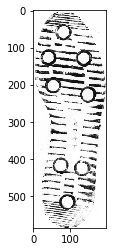

In [91]:
i = 3
f(i)
print(pos_array[i])
plt.imshow(ref_img_list[label_table[i, 1]-1])

0


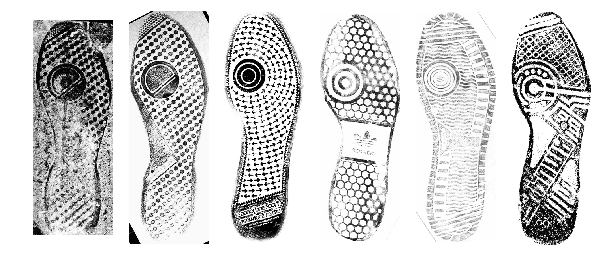

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

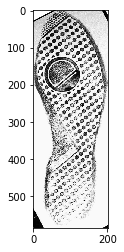

In [92]:
i = 11
f(i)
print(pos_array[i])
plt.imshow(ref_img_list[label_table[i, 1]-1])

2


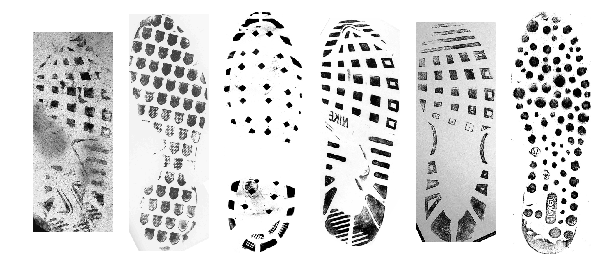

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

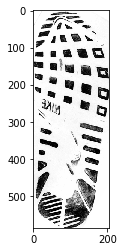

In [93]:
i = 5
f(i)
print(pos_array[i])
plt.imshow(ref_img_list[label_table[i, 1]-1])

118


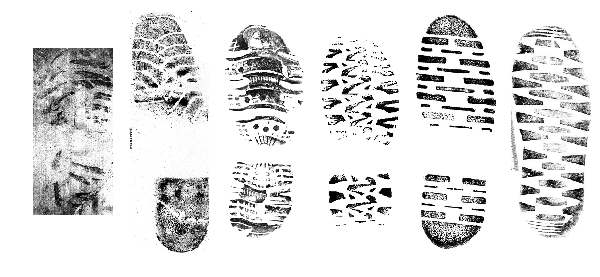

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

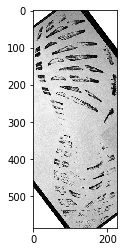

In [94]:
i = 30
f(i)
print(pos_array[i])
plt.imshow(ref_img_list[label_table[i, 1]-1])

685


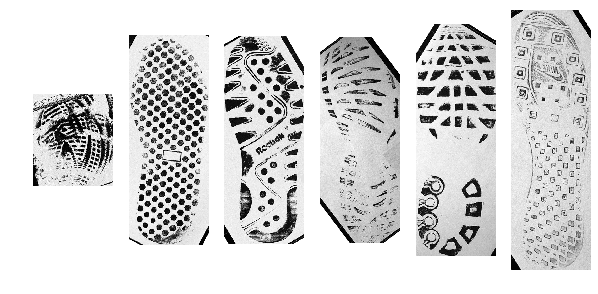

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

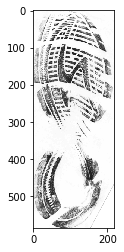

In [90]:
i = 33
f(i)
print(pos_array[i])
plt.imshow(ref_img_list[label_table[i, 1]-1])

## Cosine distance

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(cuda=True, layer_output_size=2048, centre_crop=True)
print(img2vec.layer_output_size)
score_layer4 = find_scores(img2vec)

# Cos sim (centre crop)
# top 5: 24.666666666666668
# top 10: 35.0


# Normalize:
# top 5: 22.333333333333332
# top 10: 30.333333333333332

In [ ]:
img2vec_layer3 = img2vec_pytorch.Img2Vec(cuda=True, layer='layer3', layer_output_size=1024, centre_crop=True)
score_layer3 = find_scores(img2vec_layer3)

# Cos
# top 5: 6.0
# top 10: 8.666666666666666

In [ ]:
img2vec_layer2 = img2vec_pytorch.Img2Vec(cuda=True, layer='layer2', layer_output_size=512, centre_crop=True)
score_layer2 = find_scores(img2vec_layer2)

# Cos
# top 5: 7.0
# top 10: 11.0

In [ ]:
img2vec_layer1 = img2vec_pytorch.Img2Vec(cuda=True, layer='layer1', layer_output_size=256, centre_crop=True)
score_layer1 = find_scores(img2vec_layer1)

#Cos
# top 5: 5.333333333333333
# top 10: 7.0

## Top crop

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(cuda=True, layer_output_size=2048, top_crop=True)
print(img2vec.layer_output_size)
score_layer4 = find_scores(img2vec, 2048)


In [ ]:
img2vec_layer3 = img2vec_pytorch.Img2Vec(cuda=True, layer='layer3', layer_output_size=1024, top_crop=True)
score_layer3 = find_scores(img2vec_layer3, 1024)

In [ ]:
img2vec_layer2 = img2vec_pytorch.Img2Vec(cuda=True, layer='layer2', layer_output_size=512, top_crop=True)
score_layer2 = find_scores(img2vec_layer2, 512)

In [ ]:
img2vec_layer1 = img2vec_pytorch.Img2Vec(cuda=True, layer='layer1', layer_output_size=256, top_crop=True)
score_layer1 = find_scores(img2vec_layer1, 256)

## No crop

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(cuda=True, layer_output_size=2048)
print(img2vec.layer_output_size)
score_layer4 = find_scores(img2vec, 2048)


In [ ]:
img2vec_layer3 = img2vec_pytorch.Img2Vec(cuda=True, layer='layer3', layer_output_size=1024)
score_layer3 = find_scores(img2vec_layer3, 1024)

In [ ]:
img2vec_layer2 = img2vec_pytorch.Img2Vec(cuda=True, layer='layer2', layer_output_size=512)
score_layer2 = find_scores(img2vec_layer2, 512)

In [ ]:
img2vec_layer1 = img2vec_pytorch.Img2Vec(cuda=True, layer='layer1', layer_output_size=256)
score_layer1 = find_scores(img2vec_layer1, 256)

### Average over channels instead of over pixels

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer1', layer_output_size=256, 
    channels=56, return_embedding=True)
score_layer2_conv = find_scores(img2vec, 3136, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer2', layer_output_size=128, 
    channels=28, return_embedding=True)
score_layer2_conv = find_scores(img2vec, 784, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer3', layer_output_size=256, 
    channels=14, return_embedding=True)
score_layer2_conv = find_scores(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer4', layer_output_size=512, 
    channels=7, return_embedding=True)
score_layer2_conv = find_scores(img2vec, 49, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer1', layer_output_size=64, 
    channels=56, return_embedding=True, centre_crop=True)
score_layer2_conv = find_scores(img2vec, 3136, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer2', layer_output_size=128, 
    channels=28, return_embedding=True, centre_crop=True)
score_layer2_conv = find_scores(img2vec, 784, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer3', layer_output_size=256, 
    channels=14, return_embedding=True, centre_crop=True)
score_layer2_conv = find_scores(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer4', layer_output_size=512, 
    channels=7, return_embedding=True, centre_crop=True)
score_layer2_conv = find_scores(img2vec, 49, return_tensor=True)

## MCNCC

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer4', layer_output_size=256, 
    channels=14, return_embedding=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

# BEST MODEL

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer3', layer_output_size=256, 
    channels=14, return_embedding=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer2', layer_output_size=256, 
    channels=14, return_embedding=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer1', layer_output_size=256, 
    channels=14, return_embedding=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

## MCNCC (Centre crop)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer4', layer_output_size=256, 
    channels=14, return_embedding=True, centre_crop=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer3', layer_output_size=256, 
    channels=14, return_embedding=True, centre_crop=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer2', layer_output_size=256, 
    channels=14, return_embedding=True, centre_crop=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer1', layer_output_size=256, 
    channels=14, return_embedding=True, centre_crop=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

## MCNCC (Top crop)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer4', layer_output_size=256, 
    channels=14, return_embedding=True, top_crop=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer3', layer_output_size=256, 
    channels=14, return_embedding=True, top_crop=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer2', layer_output_size=256, 
    channels=14, return_embedding=True, top_crop=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer1', layer_output_size=256, 
    channels=14, return_embedding=True, top_crop=True)
score_layer2_conv = find_scores_mcncc(img2vec, 196, return_tensor=True)

# ROUGH USE

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

layer_id = 5
model = models.resnet50(pretrained=True)
modules = list(model.children())[:layer_id] 
net_base = nn.Sequential(*modules)

In [ ]:
modules

In [ ]:
list(model.children())

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer3', layer_output_size=256, 
    channels=14, return_embedding=True)

 

In [ ]:
a = img2vec.get_vec(ref_img_list[0]).numpy()
# test_vec_list = np.array([img2vec.get_vec(img).numpy() for img in test_img_list])

# ref_vec_list = ref_vec_list.reshape(ref_vec_list.shape[0], ref_vec_list.shape[2],ref_vec_list.shape[3]*ref_vec_list.shape[4])
# test_vec_list = test_vec_list.reshape(test_vec_list.shape[0], test_vec_list.shape[2], test_vec_list.shape[3]*test_vec_list.shape[4])


In [ ]:
ref_vec_list = np.array([img2vec.get_vec(img).numpy() for img in ref_img_list])
test_vec_list = np.array([img2vec.get_vec(img).numpy() for img in test_img_list])

In [ ]:
ref_vec_list.shape

In [ ]:
ref_vec_list = ref_vec_list.reshape(ref_vec_list.shape[0], ref_vec_list.shape[2],ref_vec_list.shape[3]*ref_vec_list.shape[4])
test_vec_list = test_vec_list.reshape(test_vec_list.shape[0], test_vec_list.shape[2], test_vec_list.shape[3]*test_vec_list.shape[4])

In [ ]:
ref_vec_list.shape

In [ ]:
test_vec_list = (test_vec_list-test_vec_list.mean(1)[:, None])/test_vec_list.std(1)[:, None]
ref_vec_list = (ref_vec_list-ref_vec_list.mean(1)[:, None])/ref_vec_list.std(1)[:, None]

In [ ]:
img = ref_img_list[0]

In [ ]:
img.shape

In [ ]:
img2vec.scaler(img2vec.to_tensor(img))

In [ ]:
img2vec.to_tensor(img).shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
width, height = img.size
img.crop((0, 0, width, width))

In [ ]:
img.shape

In [ ]:
a = np.random.rand(2,2,2,2)

In [ ]:
a

In [ ]:
img2vec = img2vec_pytorch.Img2Vec(
    cuda=True, layer='layer3', layer_output_size=256, 
    channels=14, return_embedding=True)

In [ ]:
ref_vec_list = np.array([img2vec.get_vec(img).numpy() for img in ref_img_list])
test_vec_list = np.array([img2vec.get_vec(img).numpy() for img in test_img_list])
ref_vec_list.shape

In [ ]:
ref_vec_list = ref_vec_list.reshape(ref_vec_list.shape[0], ref_vec_list.shape[2],ref_vec_list.shape[3]*ref_vec_list.shape[4])
test_vec_list = test_vec_list.reshape(test_vec_list.shape[0], test_vec_list.shape[2], test_vec_list.shape[3]*test_vec_list.shape[4])
ref_vec_list.shape

In [ ]:
test_vec_list = (test_vec_list-test_vec_list.mean(1)[:, None])/test_vec_list.std(1)[:, None]
ref_vec_list = (ref_vec_list-ref_vec_list.mean(1)[:, None])/ref_vec_list.std(1)[:, None]

In [ ]:
ref_vec_list.shape

In [ ]:
ref_vec_list@test_vec_list.T

In [ ]:
np.zeros((2,2,2,2))[:, None].shape

In [ ]:
test_vec_list.mean(2)[:, None].shape

In [ ]:
test_vec_list-test_vec_list.mean(2)[:, None]

In [ ]:
import torch
torch.tensor([1,2,3.0]).norm(axis=0)